# C23-PR588 GBP/IDR DNN MODEL 

Import necessary libraries

In [84]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [85]:
CURRENCIES_CSV = './currency_data_10_years.csv'

# Create dataframe by using datas from csv file
currencies_df = pd.read_csv(CURRENCIES_CSV)

# Create new dataframe containing ONLY needed data for the model
gbp_idr_df = currencies_df[['date', 'GBP']]

# Displaying the first and last 5 row of data to understand the contents of the data
display(gbp_idr_df.head())
display(gbp_idr_df.tail())

,date,GBP
0,2013-05-01,15125.789759
1,2013-05-02,15096.787469
2,2013-05-03,15125.784565
3,2013-05-04,15148.170100
4,2013-05-05,15097.625177


,date,GBP
3648,2023-04-27,18363.255081
3649,2023-04-28,18443.198537
3650,2023-04-29,18451.257845
3651,2023-04-30,18421.208189
3652,2023-05-01,18322.202251


Each data point is composed of the date and the recorded exchange rate from GBP to IDR

## Parsing the raw data
Read the data from the csv file and Creating global (G) dataclass

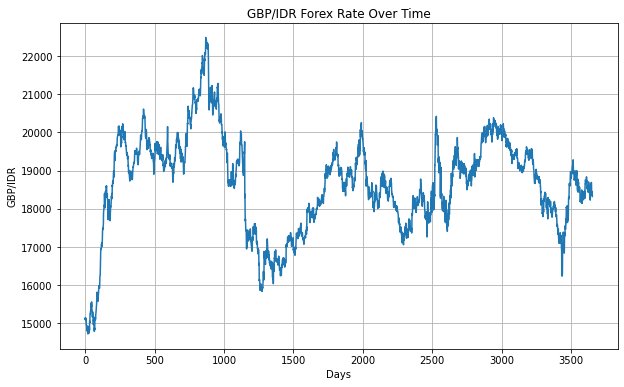

In [86]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    
    DATAFRAME = gbp_idr_df
    times, values = parse_data_from_df(DATAFRAME, 'GBP')
    TIME = times
    SERIES = values
    SPLIT_TIME = 3200
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, title="GBP/IDR Forex Rate Over Time", xlabel="Days", ylabel="GBP/IDR")

## Processing the data

train_val_split and windowed_dataset functions taken from 'tensorflow-sequences-time-series-and-prediction' courses in Coursera

In [87]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME)

In [88]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

## Defining the model architecture

In [89]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(30, input_shape=[G.WINDOW_SIZE], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)

    ])

    return model

In [90]:
# Create and test model
model = create_model()

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Adjusting the learning rate

In [92]:
def adjust_learning_rate(dataset, model_to_train):

    model = model_to_train

    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer)
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [93]:
# Run the training with dynamic LR
history = adjust_learning_rate(train_set, model)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 1935.8475 - lr: 1.0000e-08
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 222.9021 - lr: 1.1220e-08
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 218.7162 - lr: 1.2589e-08
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 218.6531 - lr: 1.4125e-08
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 218.7330 - lr: 1.5849e-08
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 217.4660 - lr: 1.7783e-08
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 214.0869 - lr: 1.9953e-08
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 231.7499 - lr: 2.2387e-08
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 212.9640 - lr: 2.5119e-08
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 204.7079 - lr:

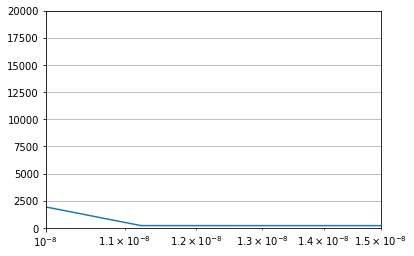

In [94]:
# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

In [95]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Compiling the model

In [96]:
def compile_model(dataset, model_to_train):

    model = model_to_train

    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
        
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
    
    # Train the model
    history = model.fit(dataset, epochs=100)

    return history

In [97]:
history = compile_model(train_set, model)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 1942.1998 - mae: 1942.6998
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 220.5076 - mae: 221.0074
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 224.7113 - mae: 225.2108
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 220.3078 - mae: 220.8074
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 214.1251 - mae: 214.6247
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 211.9467 - mae: 212.4467
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 210.2755 - mae: 210.7747
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 210.3650 - mae: 210.8644
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 210.1449 - mae: 210.6444
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 207.4525 - mae: 207.95

## Visualize MAE and loss

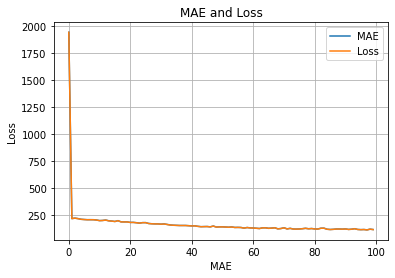

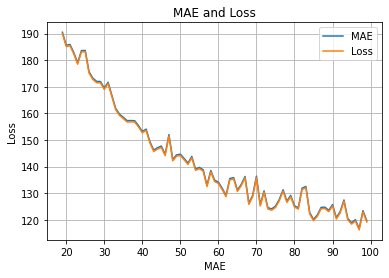

In [98]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    time=epochs_zoom, 
    series=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

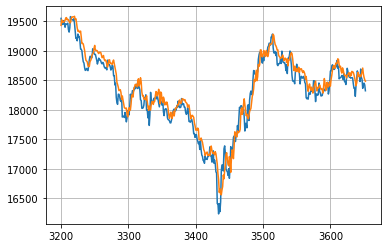

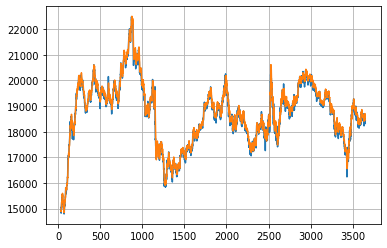

In [99]:
# Slice the forecast to get only the predictions for the validation set
dnn_forecast_valid_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Compute the forecast for all the series
dnn_forecast_valid = model_forecast(model, dnn_forecast_valid_series, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
dnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()

# Plot the forecast
plot_series(time_valid, (series_valid, dnn_forecast_valid))
plot_series(G.TIME[G.WINDOW_SIZE-1:], (G.SERIES[G.WINDOW_SIZE-1:], dnn_forecast))

In [100]:
compute_metrics(series_valid, dnn_forecast_valid)

{'mae': array([1171.0131 , 1076.7268 , 1076.7233 , 1076.9954 , 1134.883  ,
        1094.8959 , 1033.6294 , 1084.3917 , 1079.6416 , 1083.946  ,
        1094.8451 ,  995.36224,  960.0756 , 1026.121  , 1200.9281 ,
        1153.3086 , 1153.7156 , 1150.4857 , 1138.5323 , 1164.6853 ,
        1090.1141 ,  974.01434,  868.37616,  875.92645,  833.4332 ,
         931.54956,  892.407  ,  897.95514,  834.2824 ,  719.3334 ,
         716.4559 ,  696.5287 ,  621.49274,  579.70233,  570.30756,
         536.6479 ,  522.18665,  526.2879 ,  532.70374,  523.6985 ,
         520.9796 ,  548.2086 ,  595.1325 ,  630.6818 ,  630.67566,
         611.8193 ,  619.2557 ,  722.6562 ,  703.3341 ,  661.89105,
         652.10394,  652.88464,  621.64465,  592.3674 ,  561.9932 ,
         581.44885,  612.5699 ,  596.5265 ,  597.1892 ,  586.3809 ,
         569.1253 ,  563.1779 ,  575.12787,  566.6255 ,  544.39276,
         535.39465,  538.12506,  533.15753,  525.10535,  593.42377,
         571.47925,  556.638  ,  556.6371

In [101]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_valid[-2:]}')

2 last Actual Price = [[18421.208189]
 [18322.202251]], Predicted Price = [18507.416 18484.004]


## Future Predictions

In [102]:
into_future = 100

future_forecast = make_future_forecast(values=G.SERIES,
                                       model=model,
                                       into_future=into_future,
                                       window_size=G.WINDOW_SIZE)

1/1 [==============================] - 0s 20ms/step
Predicting on:
 [[18427.829335]
 [18536.88797 ]
 [18702.750877]
 [18650.934099]
 [18583.191715]
 [18553.673991]
 [18558.143788]
 [18536.744998]
 [18540.884688]
 [18546.138125]
 [18538.627127]
 [18443.833713]
 [18365.693695]
 [18364.357784]
 [18227.360896]
 [18397.814532]
 [18516.321752]
 [18658.729432]
 [18605.783192]
 [18573.621657]
 [18572.905887]
 [18478.873506]
 [18690.378712]
 [18549.081459]
 [18515.02075 ]
 [18363.255081]
 [18443.198537]
 [18451.257845]
 [18421.208189]
 [18322.202251]] -> Prediction: 18455.392578125

1/1 [==============================] - 0s 49ms/step
Predicting on:
 [18536.88797    18702.750877   18650.934099   18583.191715
 18553.673991   18558.143788   18536.744998   18540.884688
 18546.138125   18538.627127   18443.833713   18365.693695
 18364.357784   18227.360896   18397.814532   18516.321752
 18658.729432   18605.783192   18573.621657   18572.905887
 18478.873506   18690.378712   18549.081459   18515.0207

In [103]:
start_future = G.TIME[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, G.TIME[-1])
future_forecast = np.insert(future_forecast, 0, G.SERIES[-1])

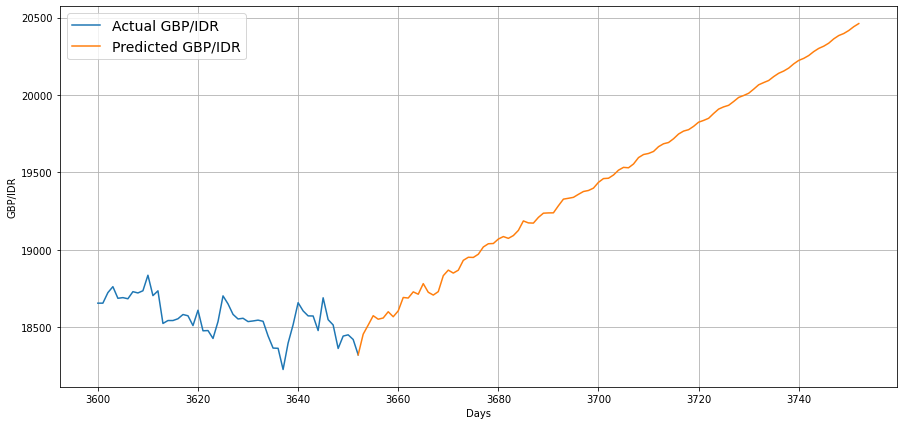

In [104]:
plt.figure(figsize=(15,7))
plot_future_forecast(G.TIME, G.SERIES, start=3600, format="-", label="Actual GBP/IDR", xlabel="Days", ylabel="GBP/IDR")
plot_future_forecast(future_time, future_forecast, format="-", label="Predicted GBP/IDR", xlabel="Days", ylabel="GBP/IDR")

### Model is unstable and mostly overfitted, the MAE is over 100 which make this model a bad model